In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = "/content/drive/MyDrive/llm_project"   # adjust as you like
!mkdir -p $root_dir

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q bitsandbytes accelerate transformers datasets
!git clone https://github.com/jwkirchenbauer/lm-watermarking.git
%cd lm-watermarking
!pip install -q -r requirements.txt

Cloning into 'lm-watermarking'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 336 (delta 19), reused 6 (delta 6), pack-reused 294 (from 2)
Receiving objects: 100% (336/336), 12.00 MiB | 26.42 MiB/s, done.
Resolving deltas: 100% (98/98), done.
/content/iconf22-paraphrase/NLM/lm-watermarking/lm-watermarking


In [ ]:
from datasets import load_dataset
import pandas as pd

dataset = pd.read_csv('/content/drive/MyDrive/llm_project/sentences.csv')
print(dataset.head())

                                            sentence          source
0  The solar system consists of the Sun and the o...       Wikipedia
1  Quantum computing leverages quantum mechanics ...           arXiv
2  The impact of social media on mental health ha...  Student Thesis
3  Photosynthesis is the process by which green p...       Wikipedia
4  Machine learning models require large datasets...           arXiv


In [ ]:
import torch
from accelerate import Accelerator, init_empty_weights
from accelerate.utils import set_seed
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, LogitsProcessorList
from extended_watermark_processor import WatermarkLogitsProcessor

model_name = "facebook/opt-1.3b"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model      = AutoModelForCausalLM.from_pretrained(model_name).to("cuda")

# 3. Set up watermark processor
watermark_processor = WatermarkLogitsProcessor(
    vocab          = list(tokenizer.get_vocab().values()),
    gamma          = 0.25,
    delta          = 2.0,
    seeding_scheme = "selfhash"
)
from transformers import LogitsProcessorList
logits_processor = LogitsProcessorList([watermark_processor])

In [ ]:
def generate_watermarked_paraphrase(prompt, max_new_tokens=50):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens   = max_new_tokens,
        logits_processor = logits_processor,
        do_sample        = True,
        top_p            = 0.9
    )
    new_tokens = outputs[0][inputs.input_ids.shape[-1]:]
    return tokenizer.decode(new_tokens, skip_special_tokens=True)

# 5. Apply to each example
def add_watermark(example):
    text = example.get("sentence", "")
    example["watermarked_paraphrase"] = generate_watermarked_paraphrase(
        text,
        max_new_tokens = len(text.split()) * 2
    )
    return example

watermarked_df = dataset.apply(add_watermark, axis=1)[["watermarked_paraphrase"]]

# 6. Save results
watermarked_df.to_csv("watermarked_paraphrases.csv", index=False)
print("Done! Download with:")
print("  from google.colab import files; files.download('watermarked_paraphrases.csv')")

Done! Download with:
  from google.colab import files; files.download('watermarked_paraphrases.csv')


In [ ]:
from google.colab import files
files.download('watermarked_paraphrases.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dataset = pd.read_csv('/content/sample_data/watermarked_paraphrases_reordered.csv')
print(dataset)

                               watermarked_paraphrase          source
0   \n\nThe sun's surface reflects light back into...       Wikipedia
1    The more powerful the quantum system, the mor...           arXiv
2    In a landmark 2018 study, researchers from th...  Student Thesis
3    There are two major pathways by which photosy...       Wikipedia
4   \n\nData are typically gathered by manually ga...           arXiv
..                                                ...             ...
91   In such cases the data is decompressed by a n...           arXiv
92   The lack of access to credit for the informal...  Student Thesis
93   Why wouldn't the same affect the Moon? I don'...       Wikipedia
94        \n\nGoogle’s Deep Brain Chain — the company           arXiv
95   Yet despite the benefits—better workers, bett...  Student Thesis

[96 rows x 2 columns]


In [6]:
!git clone https://github.com/jpwahle/iconf22-paraphrase.git
%cd iconf22-paraphrase/NLM
!chmod +x prepare_data.sh
!./prepare_data.sh
!python -m textblob.download_corpora
!python -m nltk.downloader punkt
!pip install transformers datasets torch scikit-learn --quiet
!pip install -q datasets

Cloning into 'iconf22-paraphrase'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 85 (delta 41), reused 45 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (85/85), 826.69 KiB | 5.58 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/iconf22-paraphrase/NLM/iconf22-paraphrase/NLM
File ‘/automated_evaluation_up.zip’ already there; not retrieving.
error:  must specify directory to which to extract with -d option
unzip:  cannot find or open /automated_evaluation_up/spinbot/corpus/paragraphs/arxiv_paragraph.zip, /automated_evaluation_up/spinbot/corpus/paragraphs/arxiv_paragraph.zip.zip or /automated_evaluation_up/spinbot/corpus/paragraphs/arxiv_paragraph.zip.ZIP.
unzip:  cannot find or open /automated_evaluation_up/spinbot/corpus/paragraphs/arxiv_paragraph.zip, /automated_evaluation_up/spinbot/corpus/paragraphs/arxiv_paragraph.zip.zip or /automated_evaluation_up/spinbot/

In [34]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from nltk.translate.bleu_score import sentence_bleu
from textblob import TextBlob
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

In [2]:
dataset = load_dataset("jpwahle/autoregressive-paraphrase-dataset", split="train")
splits  = dataset.train_test_split(test_size=0.1, seed=42)
train_ds, val_ds = splits["train"], splits["test"]

# 2.2 Tokenizer + preprocess
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def preprocess(ex):
    enc = tokenizer(
        ex["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )
    enc["labels"] = ex["label"]
    return enc

train_ds = train_ds.map(preprocess, batched=True)
val_ds   = val_ds.map(preprocess,   batched=True)
train_ds.set_format("torch", columns=["input_ids","attention_mask","labels"])
val_ds.set_format(  "torch", columns=["input_ids","attention_mask","labels"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.97k [00:00<?, ?B/s]

dataset.tsv:   0%|          | 0.00/163M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/261990 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/235791 [00:00<?, ? examples/s]

Map:   0%|          | 0/26199 [00:00<?, ? examples/s]

In [13]:
# 2.3 Compute class weights
labels_tensor = torch.tensor([ex["labels"] for ex in train_ds])
counts        = torch.bincount(labels_tensor, minlength=2).float()
weights       = (labels_tensor.numel() / (2 * counts)).to(torch.float)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels  = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs.logits
        weight  = weights.to(model.device)
        loss_fct = CrossEntropyLoss(weight=weight)
        loss     = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# === 3. Textual‐quality metrics ===

# 3.1 Clarity via BLEU
def clarity_score(reference: str, candidate: str) -> float:
    ref = [reference.split()]
    can = candidate.split()
    return sentence_bleu(ref, can)

# 3.2 Fluency via TextBlob corrections
def fluency_score(text: str) -> float:
    blob      = TextBlob(text)
    corrected = blob.correct()
    orig, corr = blob.words, corrected.words
    if not orig:
        return 0.0
    errors = sum(1 for o,c in zip(orig,corr) if o!=c)
    return 1.0 - errors/len(orig)

# 3.3 Coherence via SBERT cosine‐sim
sbert = SentenceTransformer('all-MiniLM-L6-v2')
def coherence_score(src: str, tgt: str) -> float:
    e1 = sbert.encode(src, convert_to_tensor=True)
    e2 = sbert.encode(tgt, convert_to_tensor=True)
    return util.cos_sim(e1,e2).item()

def compute_textual_metrics(ds):
    clar, flu, coh = [], [], []
    for ex in tqdm(ds, desc="Textual metrics"):
        src, tgt = ex["text"].split(" [SEP] ")
        clar.append( clarity_score(src,tgt) )
        flu .append( fluency_score(tgt) )
        coh .append( coherence_score(src,tgt) )
    return {
        "clarity":   float(np.mean(clar)),
        "fluency":   float(np.mean(flu)),
        "coherence": float(np.mean(coh)),
    }


In [20]:
def enable_dropout(m):
    for layer in m.modules():
        if isinstance(layer, nn.Dropout):
            layer.train()

@torch.no_grad()
def predict_with_uncertainty(model, inputs, n_iter=30):
    model.eval()
    enable_dropout(model)
    probs = []
    for _ in range(n_iter):
        out = model(**inputs)
        p   = F.softmax(out.logits, dim=-1).cpu().numpy()
        probs.append(p)
    probs = np.stack(probs)             # (n_iter, batch, num_labels)
    mean_p = probs.mean(axis=0)         # (batch, num_labels)
    var_p  = probs.var(axis=0)
    entropy = -(mean_p * np.log(mean_p + 1e-12)).sum(axis=1)
    return mean_p, var_p, entropy

In [37]:
class ModelWithTemperature(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, input_ids, attention_mask):
        logits = self.base(input_ids=input_ids, attention_mask=attention_mask).logits
        return logits / self.temperature

    def set_temperature(self, valid_loader):
        self.eval()
        nll_criterion = nn.CrossEntropyLoss()
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)
        self.to(self.base.device) # ensure model and temperature are on same device
        # gather all logits & labels
        logits_list, labels_list = [], []
        with torch.no_grad():
            for batch in valid_loader:
                inputs = {k:v.to(self.temperature.device) for k,v in batch.items() if k!="labels"}
                logits = self.base(**inputs).logits
                logits_list.append(logits)
                labels_list.append(batch["labels"].to(self.temperature.device))
        logits_all = torch.cat(logits_list)
        labels_all = torch.cat(labels_list)

        def _eval():
            optimizer.zero_grad()
            loss = nll_criterion(logits_all/self.temperature, labels_all)
            loss.backward()
            return loss

        optimizer.step(_eval)
        print(f"Calibrated temperature: {self.temperature.item():.3f}")

In [22]:
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
def compute_class_metrics(p):
    preds  = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc    = accuracy_score(labels, preds)
    prf    = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": prf[0], "recall": prf[1], "f1": prf[2]}

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
training_args = TrainingArguments(
    output_dir="roberta-calibrated",
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=200,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=1,
    num_train_epochs=1,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    push_to_hub=False,
    report_to='none',
    logging_steps=50,
)
def compute_classification_metrics(p):
    preds  = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc    = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average="binary",
        zero_division=0,      # <-- ensures no warnings
    )
    return {
        "accuracy":  acc,
        "precision": precision,
        "recall":    recall,
        "f1":        f1
    }

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_classification_metrics,
)

<ipython-input-25-3e6967f35f2f>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [26]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.080800,0.077284,0.973930,0.979357,0.978573,0.978965
1000,0.066300,0.060195,0.978396,0.990242,0.974755,0.982438
1500,0.054300,0.048490,0.982633,0.992144,0.979743,0.985904
2000,0.042100,0.043902,0.985457,0.989930,0.986577,0.988251
2500,0.045400,0.046916,0.982824,0.994551,0.977649,0.986027
3000,0.026300,0.038951,0.984923,0.991990,0.983622,0.987788
3500,0.048700,0.036582,0.986221,0.993720,0.983991,0.988831


TrainOutput(global_step=3685, training_loss=0.07284329639522806, metrics={'train_runtime': 5296.0626, 'train_samples_per_second': 44.522, 'train_steps_per_second': 0.696, 'total_flos': 6.203921885438976e+16, 'train_loss': 0.07284329639522806, 'epoch': 1.0})

In [27]:
import numpy as np

results = trainer.evaluate()
print("Validation results:")
for key, value in results.items():
    print(f"  {key}: {value:.4f}")
model.save_pretrained("/content/drive/MyDrive/llm_project/roberta-plagiarism-model")
tokenizer.save_pretrained("/content/drive/MyDrive/llm_project/roberta-plagiarism-model")

Validation results:
  eval_loss: 0.0366
  eval_accuracy: 0.9862
  eval_precision: 0.9937
  eval_recall: 0.9840
  eval_f1: 0.9888
  eval_runtime: 150.5186
  eval_samples_per_second: 174.0580
  eval_steps_per_second: 2.7240
  epoch: 1.0000


('/content/drive/MyDrive/llm_project/roberta-plagiarism-model/tokenizer_config.json',
 '/content/drive/MyDrive/llm_project/roberta-plagiarism-model/special_tokens_map.json',
 '/content/drive/MyDrive/llm_project/roberta-plagiarism-model/vocab.json',
 '/content/drive/MyDrive/llm_project/roberta-plagiarism-model/merges.txt',
 '/content/drive/MyDrive/llm_project/roberta-plagiarism-model/added_tokens.json',
 '/content/drive/MyDrive/llm_project/roberta-plagiarism-model/tokenizer.json')

In [35]:
cls_metrics = trainer.evaluate()
print("Classification:", cls_metrics)

text_metrics = compute_textual_metrics(val_ds)
print("Textual quality:", text_metrics)

# 6.4 Calibrate temperature on validation set
valid_loader = DataLoader(val_ds, batch_size=32)
calibrated = ModelWithTemperature(model.to(model.device))
calibrated.set_temperature(valid_loader)

Classification: {'eval_loss': 0.03658229857683182, 'eval_accuracy': 0.9862208481239741, 'eval_precision': 0.9937196866061435, 'eval_recall': 0.9839911335508897, 'eval_f1': 0.9888314822262785, 'eval_runtime': 150.5302, 'eval_samples_per_second': 174.045, 'eval_steps_per_second': 2.724, 'epoch': 1.0}


Textual metrics:   0%|          | 0/26199 [00:00<?, ?it/s]


KeyError: 'text'

In [38]:
valid_loader = DataLoader(val_ds, batch_size=32)
calibrated = ModelWithTemperature(model) # remove .to(model.device) here, it's done in the loop
calibrated.set_temperature(valid_loader)

Calibrated temperature: 1.105


{'eval_loss': 0.03658229857683182, 'eval_accuracy': 0.9862208481239741, 'eval_precision': 0.9937196866061435, 'eval_recall': 0.9839911335508897, 'eval_f1': 0.9888314822262785, 'eval_runtime': 150.5186, 'eval_samples_per_second': 174.058, 'eval_steps_per_second': 2.724, 'epoch': 1.0}


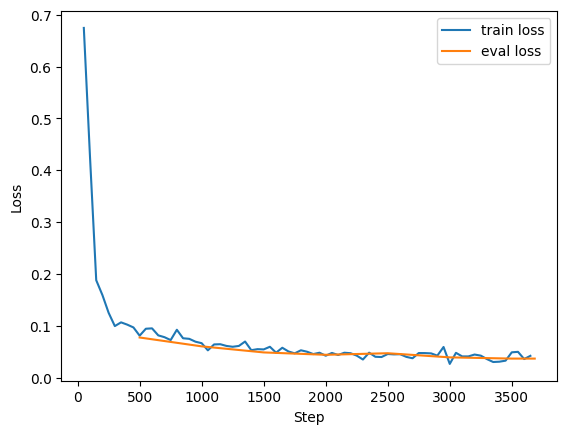

In [29]:
print(results)  # look at 'eval_loss', 'eval_f1', etc.
from transformers import TrainerCallback
import matplotlib.pyplot as plt

# Extract logged history
history = trainer.state.log_history
steps = [h["step"] for h in history if "loss" in h]
train_losses = [h["loss"] for h in history if "loss" in h]
eval_points = {h["step"]: h["eval_loss"] for h in history if "eval_loss" in h}

plt.plot(steps, train_losses, label="train loss")
plt.plot(list(eval_points.keys()), list(eval_points.values()), label="eval loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

outputs = trainer.predict(val_ds)
preds   = np.argmax(outputs.predictions, axis=1)
labels  = outputs.label_ids

print(classification_report(labels, preds, target_names=["original","plagiarized"]))
print("Confusion matrix:\n", confusion_matrix(labels, preds))

              precision    recall  f1-score   support

    original       0.97      0.99      0.98      9958
 plagiarized       0.99      0.98      0.99     16241

    accuracy                           0.99     26199
   macro avg       0.98      0.99      0.99     26199
weighted avg       0.99      0.99      0.99     26199

Confusion matrix:
 [[ 9857   101]
 [  260 15981]]


In [46]:
from sklearn.metrics import roc_curve, auc
probs = trainer.predict(val_ds).predictions[:,1]    # probabilites for “plagiarized”
fpr, tpr, thresh = roc_curve(labels, probs)
print("AUC:", auc(fpr, tpr))

AUC: 0.9992519162342561


In [47]:
from sklearn.metrics import roc_auc_score

# get train predictions & labels
train_out   = trainer.predict(train_ds)
train_probs = train_out.predictions[:,1]   # model’s “plagiarized” score
train_labels= train_out.label_ids

train_auc = roc_auc_score(train_labels, train_probs)
print("Train AUC:", train_auc)

Train AUC: 0.9995331678747176


In [48]:
def detect_plagiarism(text: str,
                      plag_threshold: float = 0.99,
                      entropy_thresh: float = 0.5,
                      n_iter: int = 30):
    """
    Returns one of: “original”, “plagiarized”, or “uncertain”.
    Uses calibrated softmax + MC‐Dropout entropy to decide.
    """
    # Tokenize & send to device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # 1) Calibrated probabilities
    calibrated.eval()
    with torch.no_grad():
        logits = calibrated(**inputs)
        probs  = F.softmax(logits, dim=-1)[0].cpu().tolist()
    orig_p, plag_p = probs

    # 2) Uncertainty via MC-Dropout
    _, _, ent = predict_with_uncertainty(model, inputs, n_iter)
    entropy = float(ent[0])

    # 3) Decide label
    if entropy > entropy_thresh:
        label = "uncertain"
    elif plag_p >= plag_threshold:
        label = "plagiarized"
    elif orig_p >= plag_threshold:
        label = "original"
    else:
        # neither class is confident enough
        label = "uncertain"

    return {
        "label":      label,
        "orig_prob":  orig_p,
        "plag_prob":  plag_p,
        "entropy":    entropy,
    }

# === 8. Example ===
print(detect_plagiarism("I don't know what is going on here"))
print(detect_plagiarism("Something here is not just right"))
print(detect_plagiarism("Here is a sample sentence"))
print(detect_plagiarism("Hello my name is John Doe and today I will be giving a presentation"))

{'label': 'plagiarized', 'orig_prob': 0.0012012743391096592, 'plag_prob': 0.9987987279891968, 'entropy': 0.0063726878724992275}
{'label': 'plagiarized', 'orig_prob': 0.0015790504403412342, 'plag_prob': 0.9984209537506104, 'entropy': 0.006796929519623518}
{'label': 'uncertain', 'orig_prob': 0.013032414950430393, 'plag_prob': 0.9869676232337952, 'entropy': 0.03962855413556099}
{'label': 'plagiarized', 'orig_prob': 0.00022293969232123345, 'plag_prob': 0.9997770190238953, 'entropy': 0.0016484966035932302}


In [ ]:
!ls /content/drive/MyDrive/llm_project/roberta-plagiarism-model

config.json			  model.safetensors.index.json
generation_config.json		  special_tokens_map.json
merges.txt			  tokenizer_config.json
model-00001-of-00002.safetensors  tokenizer.json
model-00002-of-00002.safetensors  vocab.json
model.safetensors
